### Import libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from collections import namedtuple
from scipy.signal import butter, filtfilt
from scipy.io import loadmat
from collections import namedtuple
from math import floor
from scipy import stats
import antropy as ant


import pywt
import warnings
from vmdpy import VMD
from scipy.signal import periodogram

### Read and preprocess data

In [2]:
EEG_78_CH2 = pd.read_csv('EEG_78_CH2.csv')
bis_78 = pd.read_csv('bis_78.csv')
B78=bis_78['BIS/BIS']
E78=EEG_78_CH2['BIS/EEG2_WAV']
print ('The shape of EEG signals and BIS for patient 78 is {} and {} '.format(E78.shape,B78.shape) )
print ('The type of EEG signals and BIS for patient 78 is {} and {} '.format(type(E78),type(B78)) )

The shape of EEG signals and BIS for patient 78 is (535191,) and (4180,) 
The type of EEG signals and BIS for patient 78 is <class 'pandas.core.series.Series'> and <class 'pandas.core.series.Series'> 


In [3]:
#checking for missing values

def missing_values(eeg_signal):

    # Check for missing values
    missing_values = np.isnan(eeg_signal)
    length_signals = len(eeg_signal)

    # Count the number of missing values
    num_missing_values = np.sum(missing_values)
    percentage_missing_values = (num_missing_values/length_signals)*100

    # Print the indices and values of missing values
    missing_indices = np.where(missing_values)[0]
    missing_values_list = eeg_signal[missing_indices]

    print("Missing Values:")
    print(f"Total Missing Values: {num_missing_values}")
    print(f"Percentage of Missing Values: {percentage_missing_values} %")  
missing_values(E78)

Missing Values:
Total Missing Values: 167
Percentage of Missing Values: 0.03120381321808476 %


In [4]:
E78_copy = np.copy(E78)

In [5]:
# Handling missing values

def handle_missing_values(signal):
    # Interpolate missing values using linear interpolation
    mask = np.isnan(signal)
    signal[mask] = np.interp(np.flatnonzero(mask), np.flatnonzero(~mask), signal[~mask])
    return signal
handle_missing_values(E78_copy)

array([-5.6, -5.6, -5.6, ..., -6.5, -6.5, -6.5])

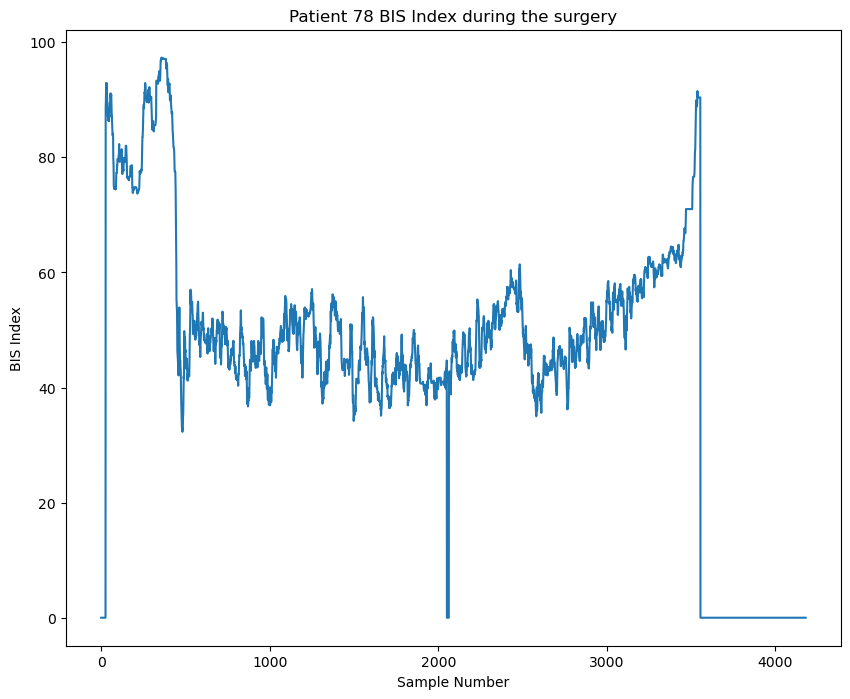

In [6]:
# Patient 78 BIS values throughout the surgery
fig = plt.figure(figsize=(10, 8))
plt.plot(B78)
plt.xlabel("Sample Number")
plt.ylabel("BIS Index")
plt.title("Patient 78 BIS Index during the surgery")
plt.show()

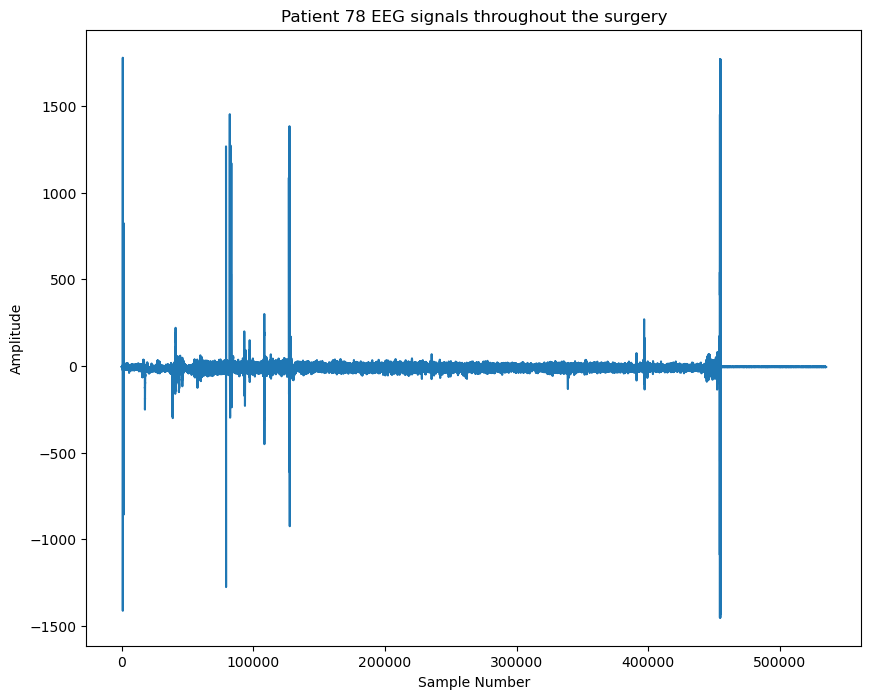

In [7]:
# Patient 78 EEG signals throughout the surgery
fig = plt.figure(figsize=(10, 8))
plt.plot(E78_copy)
plt.xlabel("Sample Number")
plt.ylabel("Amplitude")
plt.title("Patient 78 EEG signals throughout the surgery")
plt.show()

### Selecting EEG signals

In [8]:
import numpy as np

# Assuming BIS and EEG are numpy arrays
BIS = B78
EEG = E78_copy

# Define the sampling frequency
fs = 128

# Define the indices for BIS range from 200 to 800
bis_start_index = 200
bis_end_index = 800

# Convert the BIS indices to EEG indices

eeg_start_index = bis_start_index * fs
eeg_end_index = bis_end_index * fs

# Select EEG values for BIS[200:800]
selected_EEG = EEG[eeg_start_index:eeg_end_index]
selected_bis = BIS[bis_start_index:bis_end_index]
selected_bis = np.array(selected_bis)
print(selected_EEG)


[-14.8  -12.6  -13.1  ... -21.3  -21.8  -20.45]


### Bandpass filtering

In [9]:


# Define the EEG signal
eeg_signal = selected_EEG # Replace with your actual EEG signal


# Define the frequency bands
low = 8
high = 13
fs=128

# Define the filter function
def bandpass_filter(signal, lowcut, highcut, fs, order=3):
    nyquist = 0.5 * fs
    low = lowcut / nyquist
    high = highcut / nyquist
    b, a = butter(order, [low, high], btype='band')
    filtered_signal = filtfilt(b, a, signal)
    return filtered_signal

# time in seconds
time = np.arange(len(eeg_signal)) / fs

# Apply bandpass filters to the EEG signal
bpass = bandpass_filter(eeg_signal, 0.01, 63.5, fs)


### Variational Mode Decomposition (VMD)

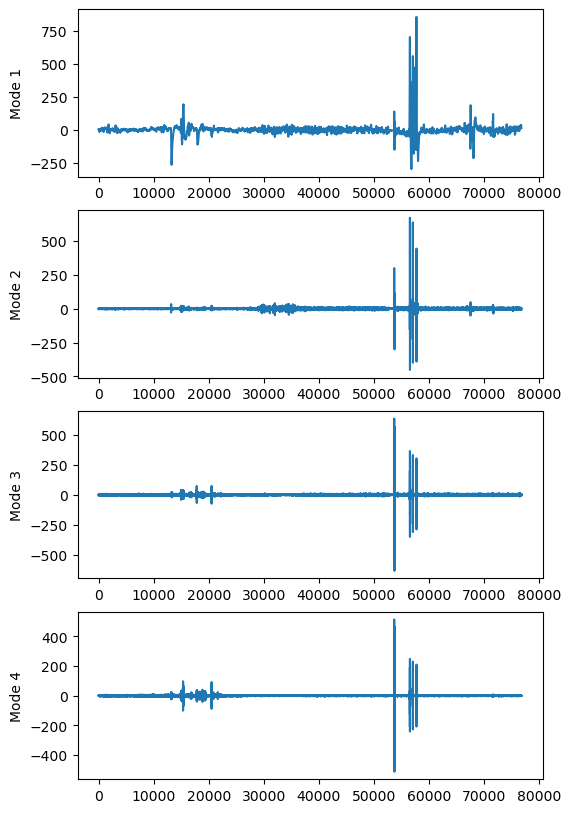

In [10]:


import numpy as np
from vmdpy import VMD

signal = bpass

# Set VMD parameters
alpha = 2000
tau = 0.5
K = 4
DC = 0
init = 1           # initialize omegas uniformly  
tol = 1e-7 

# Run VMD on the signal
modes, spectrum, omega =VMD (signal, alpha, tau, K, DC, init,tol)

#Plot the decomposed modes
import matplotlib.pyplot as plt
fig, axs = plt.subplots(K, 1, figsize=(6, 10))
for i in range(K):
    axs[i].plot(modes[i, :])
    axs[i].set_ylabel(f"Mode {i+1}")
plt.show()

### Windowing and features extraction

Number of features: 545


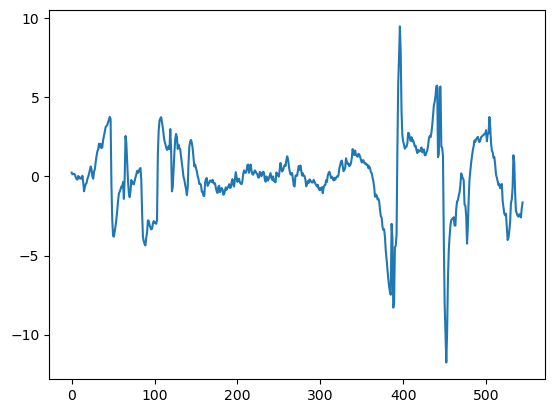

In [11]:
# For mean and standard deviation

def moving_sliding_window(data, window_size_sec, overlap_sec, sampling_rate, method):
    # Convert window size and overlap from seconds to samples
    window_size = int(window_size_sec * sampling_rate)
    overlap = int(overlap_sec * sampling_rate)

    # Calculate the stride based on the window size and overlap
    stride = window_size - overlap

    # Determine the total number of windows
    num_windows = (len(data) - window_size) // stride + 1

    # Initialize variables
    
    windows = []
    
    # Loop over the windows
    for i in range(num_windows):
        window_start = i * stride
        window_end = window_start + window_size
        window = data[window_start:window_end]
        windows.append(window)
        #window_start += stride
        
        
        if method == "mean":
            # Calculate sample entropy within the window
            results = np.mean(windows, axis=1)
            


        if method == "std":
            # Calculate sample entropy within the window
            results = np.std(windows, axis=1)

    return results

# Example usage
data = modes[0]  # Sample data
window_size_sec = 56      # Window size in seconds
overlap_sec = 55           # Overlap in seconds
sampling_rate = 128         # Sampling rate in samples per second

# Apply moving sliding window and calculate sample entropies
results = moving_sliding_window(data, window_size_sec, overlap_sec, sampling_rate, method='mean')
print(f"Number of features:", len(results))

plt.plot(results)
plt.show()

Number of features: 545


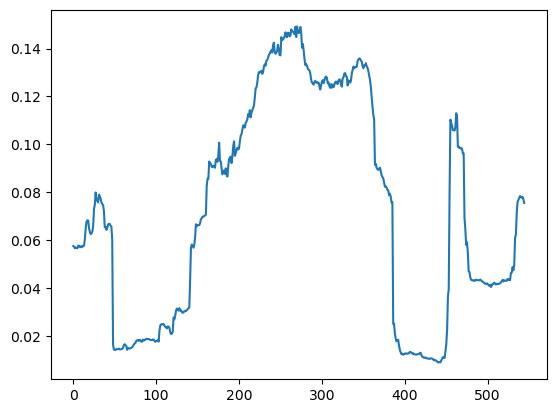

In [12]:
# For entropies

def moving_sliding_window(data, window_size_sec, overlap_sec, sampling_rate, method):
    # Convert window size and overlap from seconds to samples
    window_size = int(window_size_sec * sampling_rate)
    overlap = int(overlap_sec * sampling_rate)

    # Calculate the stride based on the window size and overlap
    stride = window_size - overlap

    # Determine the total number of windows
    num_windows = (len(data) - window_size) // stride + 1

    # Initialize variables
    
    result = []
    
    # Loop over the windows
    for i in range(num_windows):
        window_start = i * stride
        window_end = window_start + window_size
        window = data[window_start:window_end]
        
        
        if method == "sample entropy":
            # Calculate sample entropy within the window
            sample_entropy = ant.sample_entropy(window)
            result.append(sample_entropy)


        if method == "Permutation entropy":
            # Calculate sample entropy within the window
            permutation_entropy = ant.perm_entropy(window)
            result.append(permutation_entropy)

    return result

# Example usage
data = modes[0]  # Sample data
window_size_sec = 56      # Window size in seconds
overlap_sec = 55           # Overlap in seconds
sampling_rate = 128         # Sampling rate in samples per second

# Apply moving sliding window and calculate sample entropies
results = moving_sliding_window(data, window_size_sec, overlap_sec, sampling_rate, method='sample entropy')
print(f"Number of features:", len(results))

plt.plot(results)
plt.show()

Number of BIS: 545


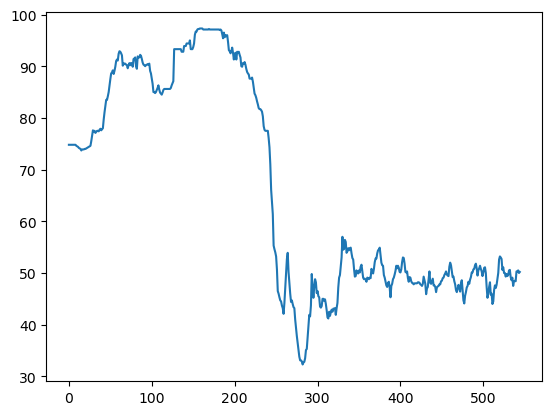

In [13]:
# For BIS

def moving_sliding_window(data, window_size_sec, overlap_sec, sampling_rate):
    # Convert window size and overlap from seconds to samples
    window_size = int(window_size_sec * sampling_rate)
    overlap = int(overlap_sec * sampling_rate)

    # Calculate the stride based on the window size and overlap
    stride = window_size - overlap

    # Determine the total number of windows
    num_windows = (len(data) - window_size) // stride + 1

    # Initialize variables
    windows = []

    # Loop over the windows
    for i in range(num_windows):
        window_start = i * stride
        window_end = window_start + window_size
        window = data[window_start:window_end][0]
        windows.append(window)

    return windows

# Example usage
data = selected_bis  # Sample data
window_size_sec = 56.0       # Window size in seconds
overlap_sec = 55           # Overlap in seconds
sampling_rate = 1         # Sampling rate in samples per second

# Apply moving sliding window
bis_windows = moving_sliding_window(data, window_size_sec, overlap_sec, sampling_rate)

# Print the number of windows and the shape of the first window
print("Number of BIS:", len(bis_windows))
plt.plot(bis_windows)
plt.show()
